# Set Up

## Libraries

In [4]:
import pandas as pd
import numpy as np
import pickle
import datetime
import re

In [5]:
# gfx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# maps
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

## Data

In [1]:
# Set paths

## List DFs

**File Names** are:

In [7]:
list(app_data.keys())

['HealthKitCharacteristics',
 'HealthKitActivitySummaries',
 'HealthKitSamples',
 'AppleLocationVisits',
 'StudyParticipants',
 'SurveyTasks',
 'SurveyResults',
 'SurveyStepResults',
 'SurveyQuestionResults',
 'SurveyConsentSignatureResults',
 'SurveyStroopResults',
 'SurveyPSATResults',
 'SurveyTrailmakingResults',
 'SurveyTowerOfHanoiResults',
 'SurveyReactionTimeResults',
 'SurveySpatialSpanMemoryResults',
 'Manifest']

## Note

Feature columns should be correct as of **March 9, 2021**

They were changed fairly substantially again in **mid September, 2021**

---

**DateTime** is in [ISO 8601 format](https://en.wikipedia.org/wiki/ISO_8601)
- e.g. `2021-03-05T13:53:52+00:00`
- the +/- offset refers to `UTC`
- but the time is CORRECT for local time
- looks like it was originally created using:

```
# UTC to ISO 8601 with Local TimeZone information without microsecond (Python 3):

import datetime
datetime.datetime.now().astimezone().replace(microsecond=0).isoformat()
>>> 2020-03-20T14:31:43+13:00
```

### Add Date

**NOTE** 
- for the `StudyDay` we will count up until 4am the *next day* to account for night owls...
    - assumption is that no one gets up before 4am
- end date seems to be `Date`
    - also seems to already be converted to local time (-4/-5)


**WARNING**

Right now we are assuming everyone is in the same timezone...(Eastern)
- What about when people travel??

In [8]:
app_data['SurveyQuestionResults'].head(3)

,SurveyQuestionResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,ResultIdentifier,Answers,StartDate,EndDate
0,d1ead919-11ae-ec11-aab9-0afb9334277d,8bead919-11ae-ec11-aab9-0afb9334277d,84ead919-11ae-ec11-aab9-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,DAILY_survey_situation1,alone,2022-03-27T23:00:37+02:00,2022-03-27T23:00:38+02:00
1,d4ead919-11ae-ec11-aab9-0afb9334277d,8dead919-11ae-ec11-aab9-0afb9334277d,84ead919-11ae-ec11-aab9-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,DAILY_survey_missed,missed_busy,2022-03-27T23:00:38+02:00,2022-03-27T23:00:44+02:00
2,daead919-11ae-ec11-aab9-0afb9334277d,8fead919-11ae-ec11-aab9-0afb9334277d,84ead919-11ae-ec11-aab9-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,DAILY_past24_ideal,82,2022-03-27T23:00:46+02:00,2022-03-27T23:01:05+02:00


In [9]:
# Add date column
app_data['SurveyQuestionResults']['StudyDay'] = 0

# Faster way than loop to do this?
for i in range(len(app_data['SurveyQuestionResults'].EndDate)):

    if pd.to_datetime(app_data['SurveyQuestionResults'].EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 4:
        # subtract one day from date
        app_data['SurveyQuestionResults'].loc[i, 'StudyDay'] = pd.to_datetime(app_data['SurveyQuestionResults'].EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        app_data['SurveyQuestionResults'].loc[i, 'StudyDay'] = pd.to_datetime(app_data['SurveyQuestionResults'].EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

### Filter by date

In this case filter out dates pre-sept 15 when the last major update was made

In [10]:
# select only dates after sept 15
app_data['SurveyQuestionResults'] = app_data['SurveyQuestionResults'].loc[app_data['SurveyQuestionResults'].StudyDay>= datetime.date(year=2021,month=9,day=15),:]

# Self Report Measures

## Affect

In [11]:
df = app_data['SurveyQuestionResults'].loc[app_data['SurveyQuestionResults'].ResultIdentifier.str.startswith('affect_'), :]
df = df[['ParticipantIdentifier', 'ResultIdentifier', 'Answers', 'StudyDay']]
df.head(3)

,ParticipantIdentifier,ResultIdentifier,Answers,StudyDay
55,01801252-3a7e-4f5f-8b6d-49e8da3902f3,affect_neg_frustrated,2,2022-03-27
56,01801252-3a7e-4f5f-8b6d-49e8da3902f3,affect_pos_relaxedCalm,2,2022-03-27
57,01801252-3a7e-4f5f-8b6d-49e8da3902f3,affect_neg_ashamed,1,2022-03-27


In [11]:
# cast Value to numeric
df.Answers = pd.to_numeric(df.Answers)

In [12]:
# convert from long to wide
df = df.pivot_table(index=['StudyDay', 'ParticipantIdentifier'],
                    columns='ResultIdentifier', 
                    values='Answers').reset_index()

# Get rid of index name
df.columns.name = None

In [13]:
keep_same = {'StudyDay', 'ParticipantIdentifier'}

# Rename columns (add prefix SR for self report)
df.columns = ['SR_' + str(col) if col not in keep_same else col for col in df.columns]
df.head(3)

,StudyDay,ParticipantIdentifier,SR_affect_neg_angry,SR_affect_neg_ashamed,SR_affect_neg_bored,SR_affect_neg_depressed,SR_affect_neg_embarrassed,SR_affect_neg_frustrated,SR_affect_neg_guilty,SR_affect_neg_lazy,...,SR_affect_neg_sad,SR_affect_neg_stressed,SR_affect_pos_amused,SR_affect_pos_appreciated,SR_affect_pos_excited,SR_affect_pos_focused,SR_affect_pos_happy,SR_affect_pos_hopeful,SR_affect_pos_motivated,SR_affect_pos_relaxedCalm
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,1.0,3.0,2.0,2.0,3.0,4.0,4.0,3.0,3.0,4.0
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,1.0,2.0,3.0,4.0,1.0,2.0,2.0,3.0,...,3.0,4.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,4.0
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,2.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0,...,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0


### Plot

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
sns.set_theme(style="white")

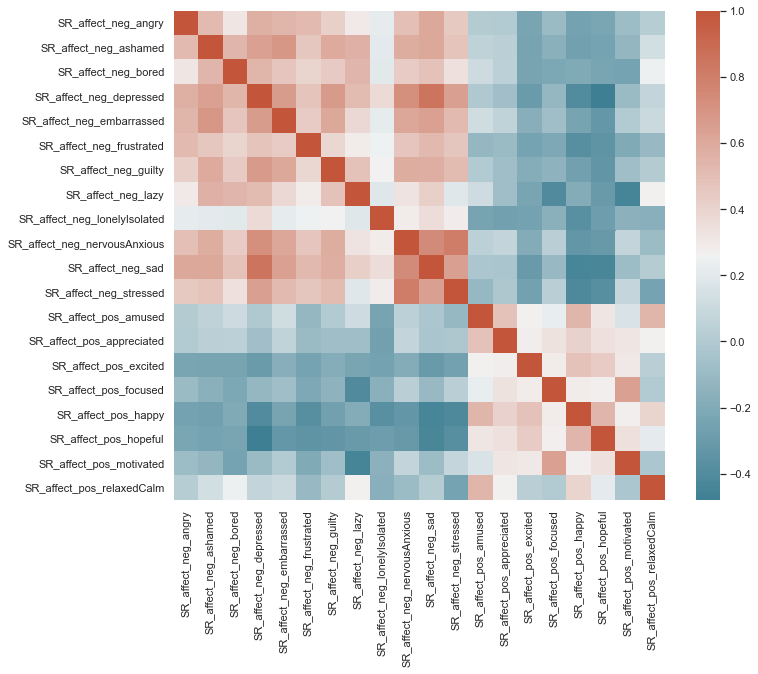

In [16]:
# Compute the correlation matrix
corrs = df.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrs, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, n=9, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corrs, cmap=cmap)

In [21]:
df.iloc[:,2:].columns.values.tolist()

['SR_affect_neg_angry',
 'SR_affect_neg_ashamed',
 'SR_affect_neg_bored',
 'SR_affect_neg_depressed',
 'SR_affect_neg_embarrassed',
 'SR_affect_neg_frustrated',
 'SR_affect_neg_guilty',
 'SR_affect_neg_lazy',
 'SR_affect_neg_lonelyIsolated',
 'SR_affect_neg_nervousAnxious',
 'SR_affect_neg_sad',
 'SR_affect_neg_stressed',
 'SR_affect_pos_amused',
 'SR_affect_pos_appreciated',
 'SR_affect_pos_excited',
 'SR_affect_pos_focused',
 'SR_affect_pos_happy',
 'SR_affect_pos_hopeful',
 'SR_affect_pos_motivated',
 'SR_affect_pos_relaxedCalm']

In [2]:
import plotly.express as px


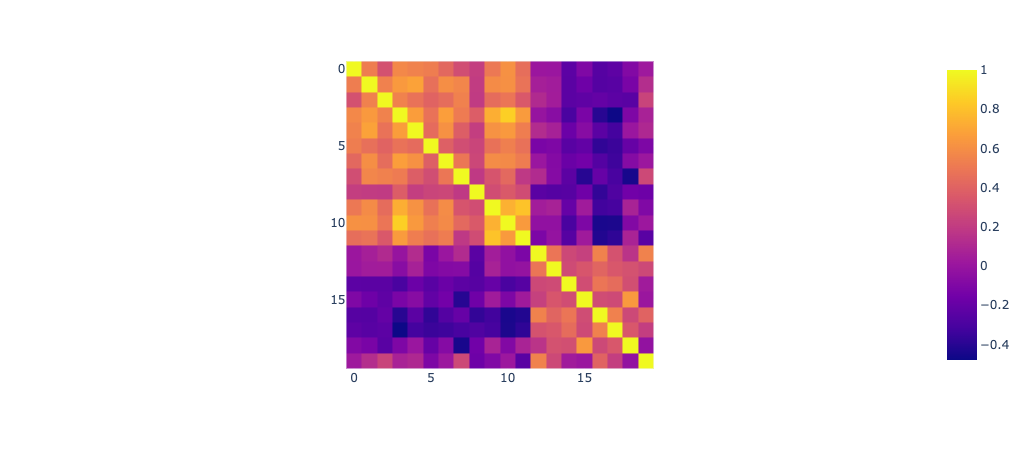

ValueError: The length of the y vector must match the length of the first dimension of the img matrix.

In [22]:
import plotly.express as px
fig = px.imshow(df.iloc[:,2:].corr())
fig.show()

df = px.data.medals_wide(indexed=True)
fig = px.imshow(df,
               x=df.iloc[:,2:].columns.values.tolist(),
                y=df.iloc[:,2:].columns.values.tolist()
               )
fig.show()

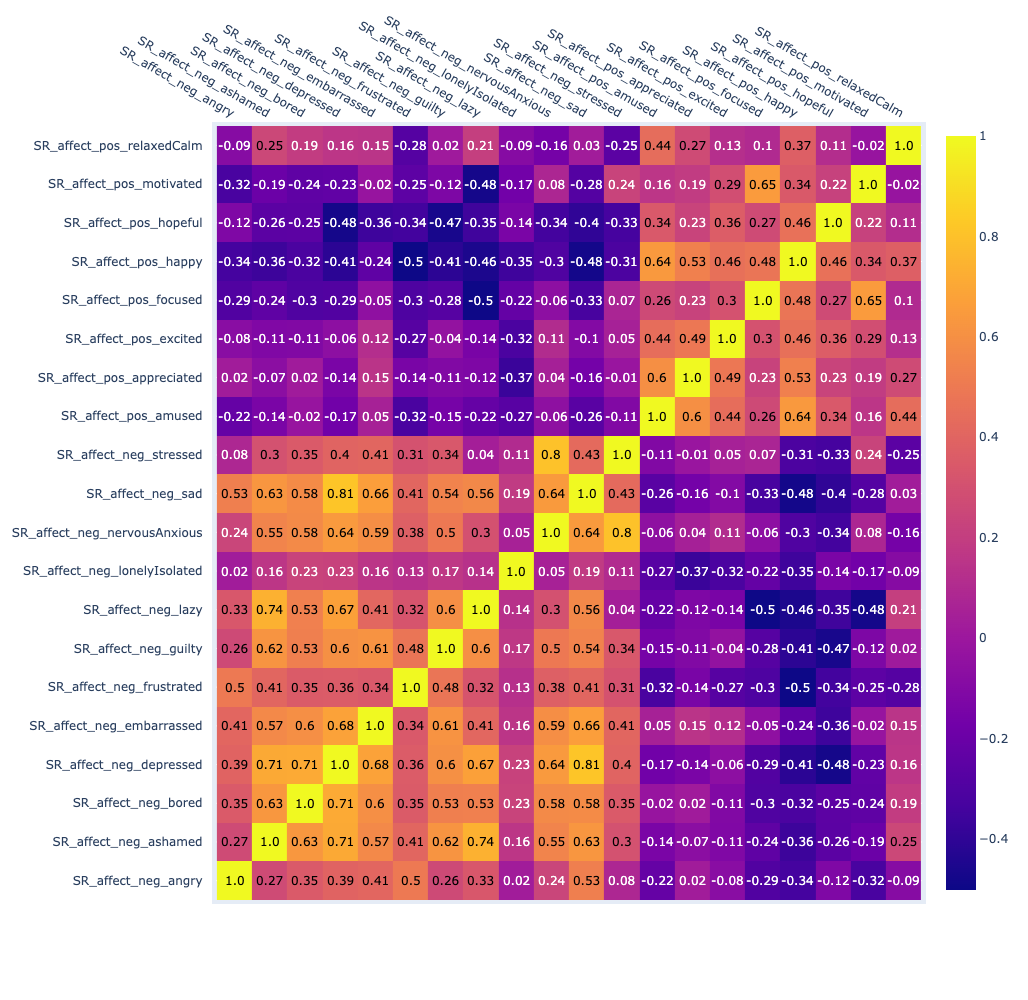

In [184]:
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

fig.update_layout(
    autosize=False,
    width=1100,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)


fig.show()

A few notes on interesting correlations:

- depressed & ashamed `0.71`
- depressed & bored `0.71`
- depressed & embarrassed `0.68`
- lazy & ashamed `0.74`
- hopeful & depressed `-0.48`
- happy & stressed `-0.42`
- focused & guilty `-0.4`


In [1]:
fig = px.line(df, x="StudyDay", y="SR_affect_neg_lazy", color='ParticipantIdentifier')
fig.show()

NameError: name 'px' is not defined

### Join

In [186]:
# create master df_tasks, as df will be reassigned
df_sr = df

## Daily Global

In [187]:
df = app_data['SurveyQuestionResults'].loc[app_data['SurveyQuestionResults'].ResultIdentifier.str.startswith('DAILY_global'), :]
df = df[['ParticipantIdentifier', 'ResultIdentifier', 'Answers', 'StudyDay']]
df.head(3)

,ParticipantIdentifier,ResultIdentifier,Answers,StudyDay
3,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_global_past24_ideal,85,2021-10-16
4,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_global_past24_satisfaction,95,2021-10-16
5,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_global_past24_noChange,0,2021-10-16


In [188]:
# cast Value to numeric
df.Answers = pd.to_numeric(df.Answers)

In [189]:
np.unique(df.ResultIdentifier)

array(['DAILY_global_past24_gap', 'DAILY_global_past24_ideal',
       'DAILY_global_past24_noChange',
       'DAILY_global_past24_noProcrastination',
       'DAILY_global_past24_productivity',
       'DAILY_global_past24_punctuality',
       'DAILY_global_past24_satisfaction'], dtype=object)

---
The scoring format changed from 0-100 to a 7 point scale for most items (except `DAILY_global_past24_gap`)


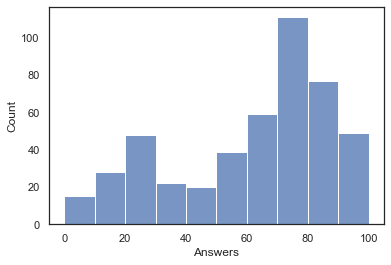

In [190]:
# take a look at the dist...
_ = sns.histplot(df.Answers[df.ResultIdentifier!='DAILY_global_past24_gap'])

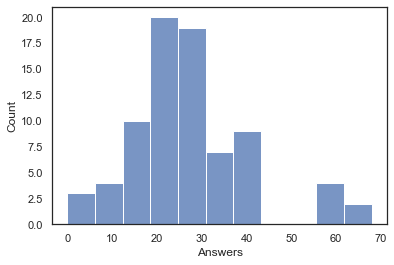

In [191]:
_ = sns.histplot(df.Answers[df.ResultIdentifier=='DAILY_global_past24_gap'])

In [192]:
# convert from long to wide
df = df.pivot_table(index=['StudyDay', 'ParticipantIdentifier'],
                    columns='ResultIdentifier', 
                    values='Answers').reset_index()

# Get rid of index name
df.columns.name = None

In [193]:
df.columns = df.columns.str.replace(r'^DAILY_', '')

In [194]:
keep_same = {'StudyDay', 'ParticipantIdentifier'}

# Rename columns (add prefix SR for self report)
df.columns = ['SR_' + str(col) if col not in keep_same else col for col in df.columns]
df.head(3)

,StudyDay,ParticipantIdentifier,SR_global_past24_gap,SR_global_past24_ideal,SR_global_past24_noChange,SR_global_past24_noProcrastination,SR_global_past24_productivity,SR_global_past24_punctuality,SR_global_past24_satisfaction
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,30.0,53.0,19.0,79.0,66.0,69.0,61.0
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,15.0,75.0,60.0,60.0,80.0,80.0,70.0
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,12.0,75.0,16.0,50.0,77.0,80.0,71.0


### Plot

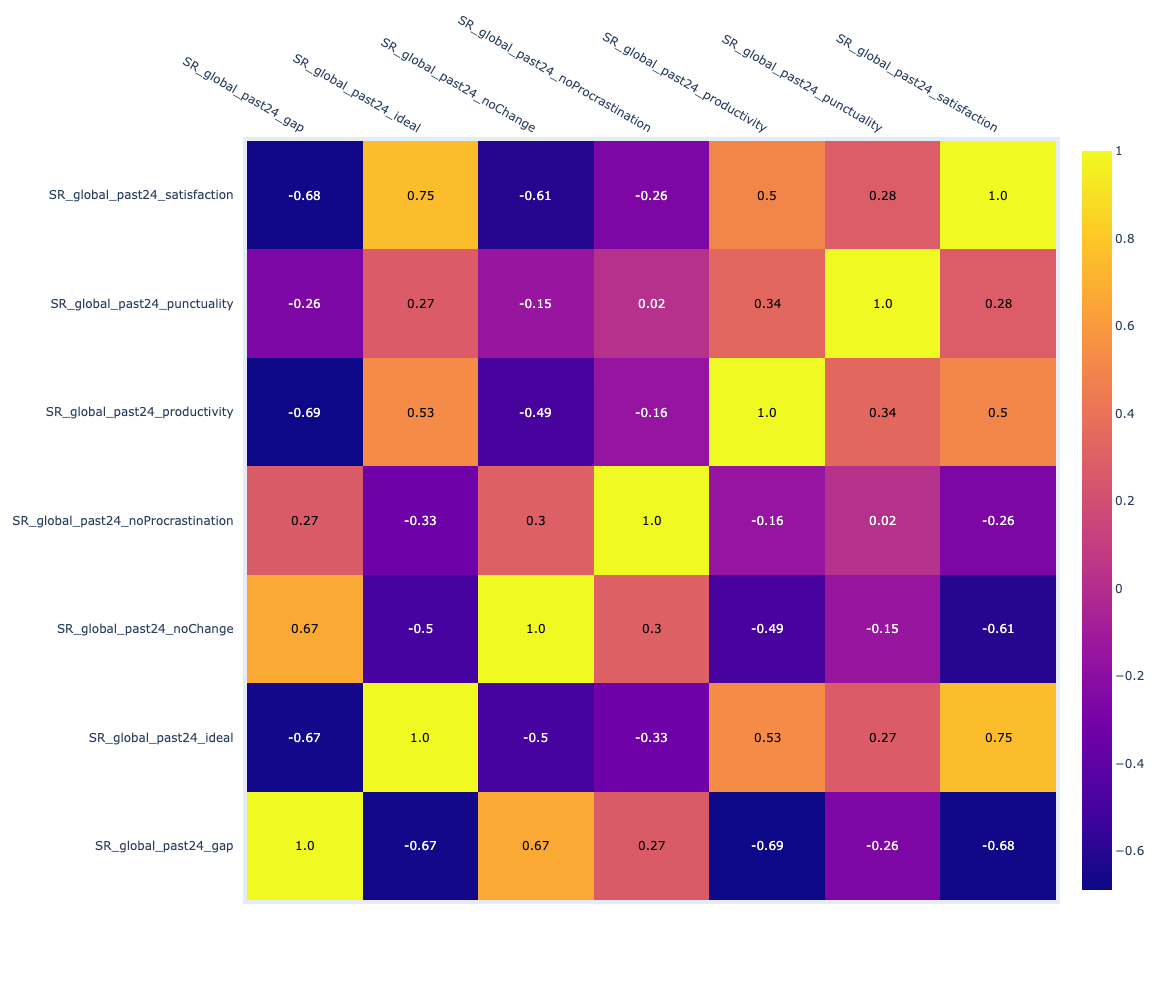

In [195]:
# Compute the correlation matrix
corrs = df.iloc[:,2:].corr()

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

fig.update_layout(
    autosize=False,
    width=1100,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)


fig.show()

Some really strong correlations:
- satisfaction & ideal `.99`
- satisfaction & productivity `.96`
- satisfactino & punctuality `.96`
- productivity & ideal `.96`
- productivity & punctuality `.94`
- change & gap `.76`
- change & satisfaction `-.71`

Satisfaction correlated with well being?

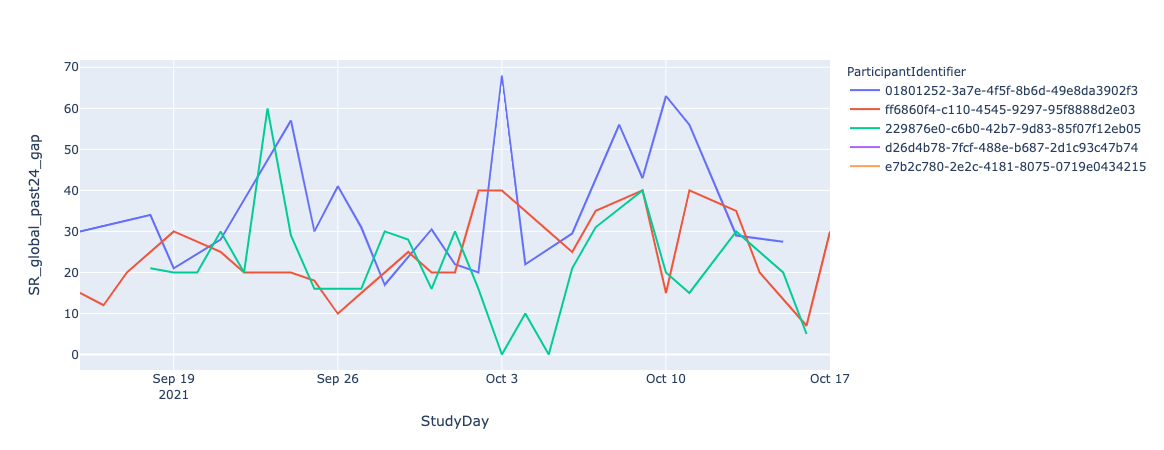

In [196]:
fig = px.line(df, x="StudyDay", y="SR_global_past24_gap", color='ParticipantIdentifier')
fig.show()

### Join

In [197]:
# join
df_sr = df_sr.merge(df, how='left', on=['ParticipantIdentifier', 'StudyDay'])
df_sr.head(3)

,StudyDay,ParticipantIdentifier,SR_affect_neg_angry,SR_affect_neg_ashamed,SR_affect_neg_bored,SR_affect_neg_depressed,SR_affect_neg_embarrassed,SR_affect_neg_frustrated,SR_affect_neg_guilty,SR_affect_neg_lazy,...,SR_affect_pos_hopeful,SR_affect_pos_motivated,SR_affect_pos_relaxedCalm,SR_global_past24_gap,SR_global_past24_ideal,SR_global_past24_noChange,SR_global_past24_noProcrastination,SR_global_past24_productivity,SR_global_past24_punctuality,SR_global_past24_satisfaction
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,3.0,3.0,4.0,30.0,53.0,19.0,79.0,66.0,69.0,61.0
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,1.0,2.0,3.0,4.0,1.0,2.0,2.0,3.0,...,2.0,2.0,4.0,15.0,75.0,60.0,60.0,80.0,80.0,70.0
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,2.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0,...,3.0,3.0,4.0,12.0,75.0,16.0,50.0,77.0,80.0,71.0


## Daily Confound

In [198]:
df = app_data['SurveyQuestionResults'].loc[app_data['SurveyQuestionResults'].ResultIdentifier.str.startswith('DAILY_confound'), :]
df = df[['ParticipantIdentifier', 'ResultIdentifier', 'Answers', 'StudyDay']]
df.head(3)

,ParticipantIdentifier,ResultIdentifier,Answers,StudyDay
10,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_confounds_past24_illness,1,2021-10-16
11,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_confounds_past24_fatigue,3,2021-10-16
12,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_confounds_past24_unusualEvents,2,2021-10-16


In [199]:
# cast Value to numeric
df.Answers = pd.to_numeric(df.Answers)

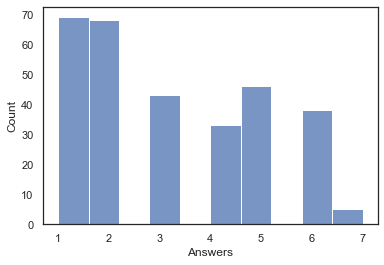

In [200]:
# take a look at the dist...
_ = sns.histplot(df.Answers)

In [201]:
# convert from long to wide
df = df.pivot_table(index=['StudyDay', 'ParticipantIdentifier'],
                    columns='ResultIdentifier', 
                    values='Answers').reset_index()

# Get rid of index name
df.columns.name = None

In [202]:
df.columns = df.columns.str.replace(r'^DAILY_', '')

In [203]:
keep_same = {'StudyDay', 'ParticipantIdentifier'}

# Rename columns (add prefix SR for self report)
df.columns = ['SR_' + str(col) if col not in keep_same else col for col in df.columns]
df.head(3)

,StudyDay,ParticipantIdentifier,SR_confounds_past24_fatigue,SR_confounds_past24_illness,SR_confounds_past24_stress,SR_confounds_past24_unusualEvents
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,6.0,1.0,3.0,3.0
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,6.0,5.0,4.0,1.0
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,4.0,3.0,5.0,1.0


### Plot

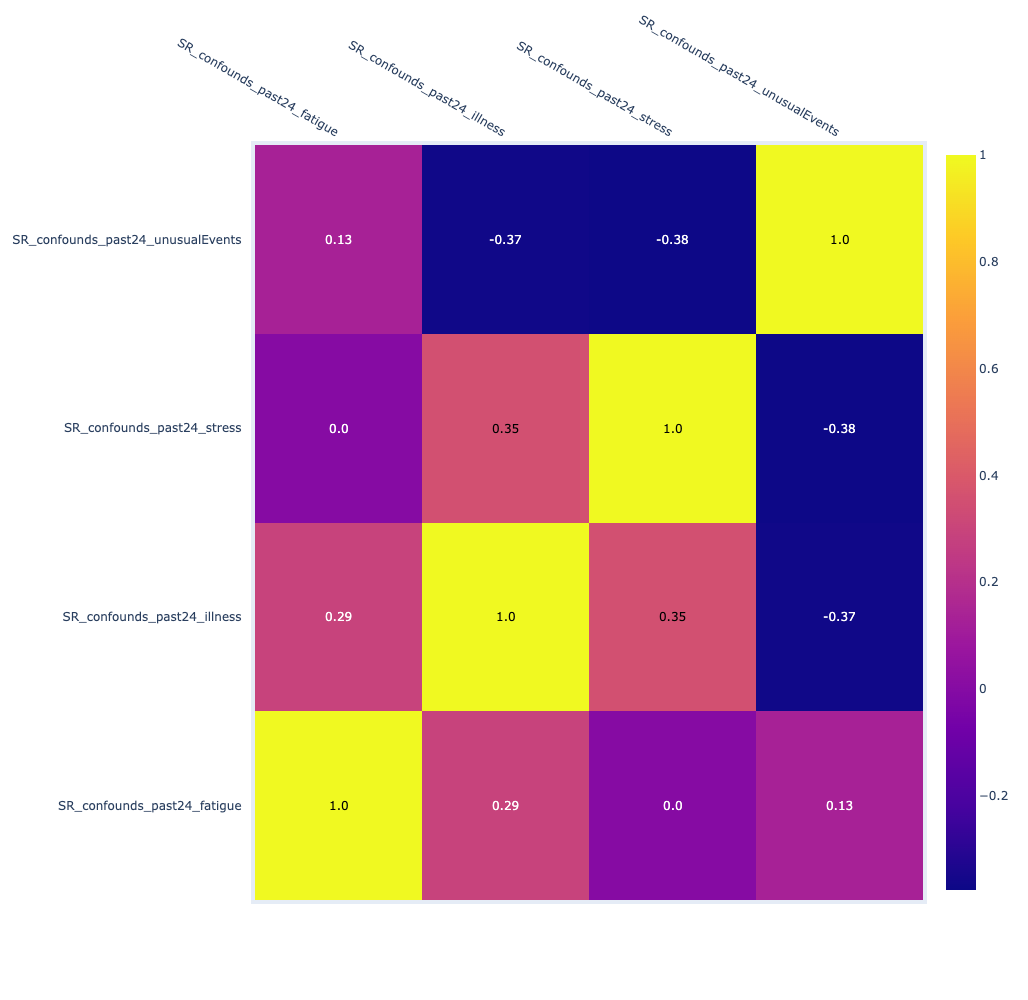

In [204]:
# Compute the correlation matrix
corrs = df.iloc[:,2:].corr()

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

fig.update_layout(
    autosize=False,
    width=1100,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)


fig.show()

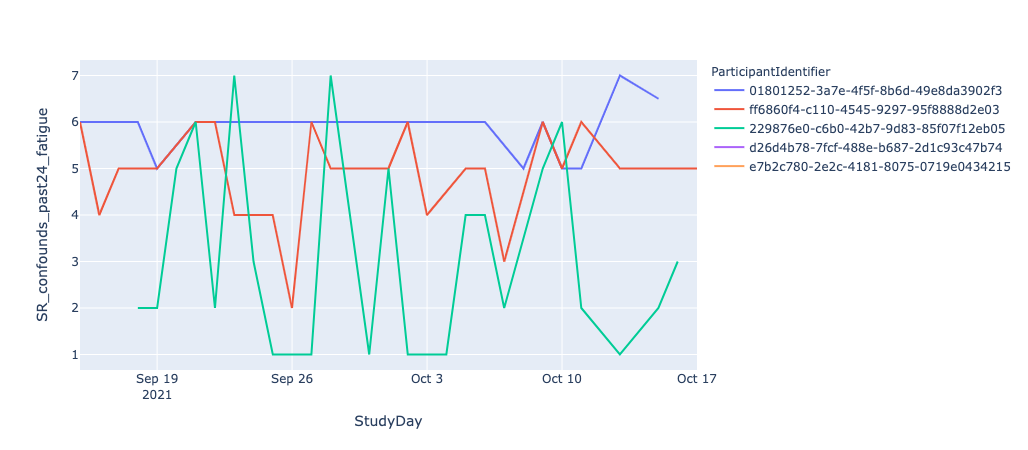

In [205]:
fig = px.line(df, x="StudyDay", y="SR_confounds_past24_fatigue", color='ParticipantIdentifier')
fig.show()

### Join

In [206]:
# join
df_sr = df_sr.merge(df, how='left', on=['ParticipantIdentifier', 'StudyDay'])
df_sr.head(3)

,StudyDay,ParticipantIdentifier,SR_affect_neg_angry,SR_affect_neg_ashamed,SR_affect_neg_bored,SR_affect_neg_depressed,SR_affect_neg_embarrassed,SR_affect_neg_frustrated,SR_affect_neg_guilty,SR_affect_neg_lazy,...,SR_global_past24_ideal,SR_global_past24_noChange,SR_global_past24_noProcrastination,SR_global_past24_productivity,SR_global_past24_punctuality,SR_global_past24_satisfaction,SR_confounds_past24_fatigue,SR_confounds_past24_illness,SR_confounds_past24_stress,SR_confounds_past24_unusualEvents
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,53.0,19.0,79.0,66.0,69.0,61.0,6.0,1.0,3.0,3.0
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,1.0,2.0,3.0,4.0,1.0,2.0,2.0,3.0,...,75.0,60.0,60.0,80.0,80.0,70.0,6.0,5.0,4.0,1.0
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,2.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0,...,75.0,16.0,50.0,77.0,80.0,71.0,4.0,3.0,5.0,1.0


## Daily Specific

In [211]:
df = app_data['SurveyQuestionResults'].loc[app_data['SurveyQuestionResults'].ResultIdentifier.str.startswith('DAILY_specific'), :]
df = df[['ParticipantIdentifier', 'ResultIdentifier', 'Answers', 'StudyDay']]
df.head(3)

,ParticipantIdentifier,ResultIdentifier,Answers,StudyDay
13,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_specific_past24_sleep,6.5,2021-10-16
14,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_specific_past24_occupation,6,2021-10-16
15,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_specific_past24_nonoccupation,0,2021-10-16


In [212]:
# questions that were just asking whether subject had a goal in a specific domain get dropped
index_names = df[ (df['Answers'] == 'True') | (df['Answers'] == 'False')].index
df.drop(index_names, inplace = True)

In [213]:
# cast Value to numeric
df.Answers = pd.to_numeric(df.Answers)

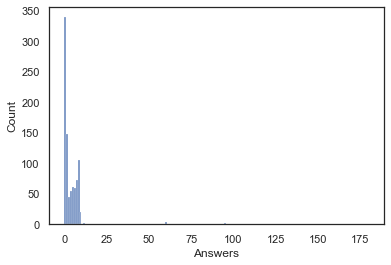

In [214]:
# take a look at the dist...
sns.histplot(df.Answers);

In [215]:
# convert from long to wide
df = df.pivot_table(index=['StudyDay', 'ParticipantIdentifier'],
                    columns='ResultIdentifier', 
                    values='Answers').reset_index()

# Get rid of index name
df.columns.name = None

In [216]:
df.columns = df.columns.str.replace(r'^DAILY_', '')

In [217]:
keep_same = {'StudyDay', 'ParticipantIdentifier'}

# Rename columns (add prefix SR for self report)
df.columns = ['SR_' + str(col) if col not in keep_same else col for col in df.columns]
df.head(3)

,StudyDay,ParticipantIdentifier,SR_specific_next24_drinks2,SR_specific_next24_exercise2,SR_specific_next24_leisureNonSolo2,SR_specific_next24_leisureSolo2,SR_specific_next24_nonoccupation2,SR_specific_next24_occupation2,SR_specific_next24_sleep2,SR_specific_past24_drinks,SR_specific_past24_exercise,SR_specific_past24_leisureNonSolo,SR_specific_past24_leisureSolo,SR_specific_past24_nonoccupation,SR_specific_past24_occupation,SR_specific_past24_sleep
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,4.0,2.2,2.0,NaN,NaN,6.0,8.0,2.0,1.2,0.2,1.0,5.5,3.0,5.0
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,NaN,1.0,NaN,NaN,NaN,7.5,8.5,0.0,0.0,1.0,1.5,1.0,8.0,7.0
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,NaN,1.0,NaN,NaN,NaN,7.5,8.0,0.0,1.0,5.0,1.5,1.0,7.0,8.5


### Plot

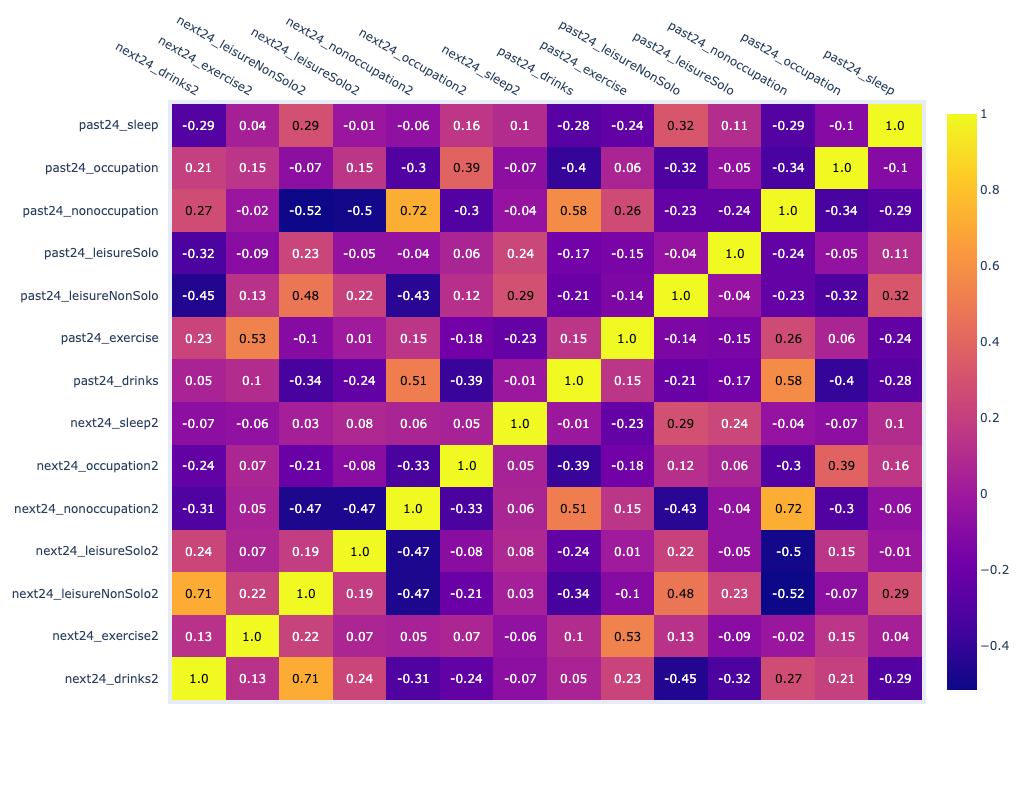

In [218]:
# clean up column names
df_plot = df.copy()

df_plot.columns = df_plot.columns.str.replace(r'^SR_specific_', '')
df_plot.columns = df_plot.columns.str.replace(r'^SR_specific_', '')

# Compute the correlation matrix
corrs = df_plot.iloc[:,2:].corr()

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

fig.update_layout(
    autosize=False,
    width=850,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)


fig.show()

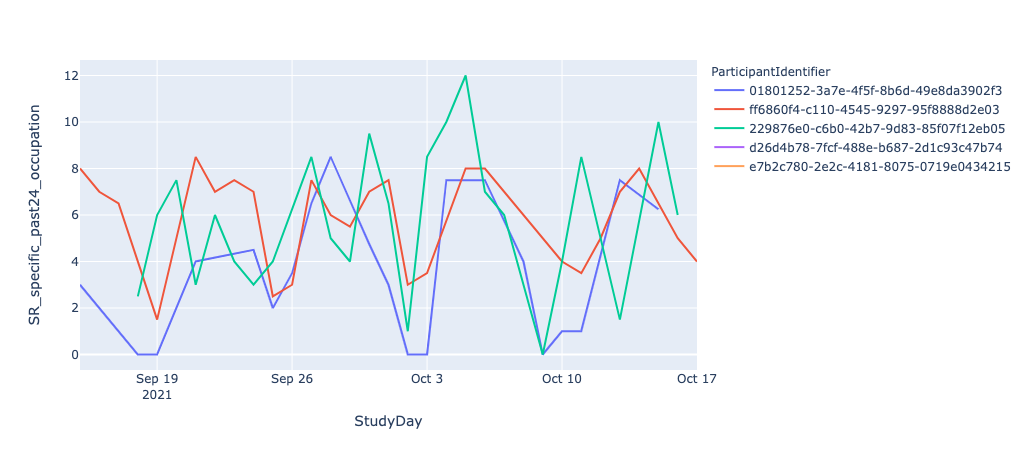

In [219]:
fig = px.line(df, x="StudyDay", y="SR_specific_past24_occupation", color='ParticipantIdentifier')
fig.show()

### Join

In [220]:
# join
df_sr = df_sr.merge(df, how='left', on=['ParticipantIdentifier', 'StudyDay'])
df_sr.head(3)

,StudyDay,ParticipantIdentifier,SR_affect_neg_angry,SR_affect_neg_ashamed,SR_affect_neg_bored,SR_affect_neg_depressed,SR_affect_neg_embarrassed,SR_affect_neg_frustrated,SR_affect_neg_guilty,SR_affect_neg_lazy,...,SR_specific_next24_nonoccupation2,SR_specific_next24_occupation2,SR_specific_next24_sleep2,SR_specific_past24_drinks,SR_specific_past24_exercise,SR_specific_past24_leisureNonSolo,SR_specific_past24_leisureSolo,SR_specific_past24_nonoccupation,SR_specific_past24_occupation,SR_specific_past24_sleep
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,NaN,6.0,8.0,2.0,1.2,0.2,1.0,5.5,3.0,5.0
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,1.0,2.0,3.0,4.0,1.0,2.0,2.0,3.0,...,NaN,7.5,8.5,0.0,0.0,1.0,1.5,1.0,8.0,7.0
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,2.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0,...,NaN,7.5,8.0,0.0,1.0,5.0,1.5,1.0,7.0,8.5


Need to calculate the gap from the `past24` with the PREVIOUS day's `next24`

## Daily Specific Gap

Need to figure out the gap as measured by the difference between one day's `next24` and the following day's `past24`.

Note that this means if there is no entry for `past24` the following day we cannot calculate a gap!

In [293]:
# note that this is inclusive of both the start and end
study_days = pd.date_range(start=df_sr.StudyDay.min(),end=df_sr.StudyDay.max())

print(f'There are a total of {len(study_days)} study days.')

There are a total of 33 study days.


---

Loop through and subtract the next day's past24 value from the current days next24 value

In [294]:
# list of columns to use for filtering
past_cols = [col for col in df_sr if col.startswith('SR_specific_past')]
next_cols = [col for col in df_sr if col.startswith('SR_specific_next')]

gap_cols = ['SR_gap_' + re.sub('SR_specific_next24_','',col) for col in df_sr if col.startswith('SR_specific_next')]
# take off a trailing 2 from weird variable naming
gap_cols = [col[:-1] for col in gap_cols]

# initialize the gap columns
for col in gap_cols:
    df_sr[col] = np.nan

In [295]:
for i in range(1,len(study_days)): # start on 2nd day so we can comepare to previous prediction
    subjects = list(df_sr.loc[df_sr.StudyDay==study_days[i]].ParticipantIdentifier)
    
    for s in subjects: # find gap for each person
        # get their past24 values
        actual = df_sr.loc[(df_sr.ParticipantIdentifier==s) & (df_sr.StudyDay==study_days[i]), past_cols].reset_index(drop=True)
        
        # just take the activity description so we can match with predicted
        actual.columns = actual.columns.str.replace(r'^SR_specific_past24_', '')
        # get their next24 values from the day BEFORE
        # first check if they have a value from the day before
        if list(df_sr.loc[(df_sr.ParticipantIdentifier==s) & (df_sr.StudyDay==study_days[i-1])].StudyDay):
            predict = df_sr.loc[(df_sr.ParticipantIdentifier==s) & (df_sr.StudyDay==study_days[i-1]), next_cols].reset_index(drop=True)
            predict.columns = predict.columns.str.replace(r'^SR_specific_next24_', '')
            # an extra removal as there was a 2 appended to the end of the 'next' variables
            predict.columns = [col[:-1] for col in predict.columns]

            # take difference
            gaps = actual.subtract(predict)
            
            # rename cols
            gaps = gaps.add_prefix('SR_gap_')
            
            # match gap index to df index
            gaps.index = df_sr.loc[(df_sr.ParticipantIdentifier==s) & (df_sr.StudyDay==study_days[i]), gap_cols].index
            
            # assign value
            df_sr.loc[(df_sr.ParticipantIdentifier==s) & (df_sr.StudyDay==study_days[i]), gap_cols] = gaps

In [296]:
df_sr.head()

,StudyDay,ParticipantIdentifier,SR_affect_neg_angry,SR_affect_neg_ashamed,SR_affect_neg_bored,SR_affect_neg_depressed,SR_affect_neg_embarrassed,SR_affect_neg_frustrated,SR_affect_neg_guilty,SR_affect_neg_lazy,...,SR_specific_past24_nonoccupation,SR_specific_past24_occupation,SR_specific_past24_sleep,SR_gap_drinks,SR_gap_exercise,SR_gap_leisureNonSolo,SR_gap_leisureSolo,SR_gap_nonoccupation,SR_gap_occupation,SR_gap_sleep
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,5.5,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,1.0,2.0,3.0,4.0,1.0,2.0,2.0,3.0,...,1.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,2.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0,...,1.0,7.0,8.5,NaN,0.00,NaN,NaN,NaN,-0.5,0.0
3,2021-09-17,ff6860f4-c110-4545-9297-95f8888d2e03,1.0,3.0,3.0,4.0,3.0,2.0,3.0,4.0,...,2.0,6.5,7.5,NaN,-0.25,NaN,NaN,NaN,-1.0,-0.5
4,2021-09-18,01801252-3a7e-4f5f-8b6d-49e8da3902f3,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,5.0,0.0,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot

In [282]:
# clean up column names
df_plot = df_sr[gap_cols].copy()
df_plot.columns = df_plot.columns.str.replace(r'^SR_', '')

df_plot.corr()

,gap_drinks,gap_exercise,gap_leisureNonSolo,gap_leisureSolo,gap_nonoccupation,gap_occupation,gap_sleep
gap_drinks,1.000000,-0.178667,-0.284868,0.060304,0.098337,-0.199093,-0.310001
gap_exercise,-0.178667,1.000000,0.232012,-0.566546,-0.325412,-0.062450,-0.120895
gap_leisureNonSolo,-0.284868,0.232012,1.000000,-0.582758,0.259824,-0.053757,0.149389
gap_leisureSolo,0.060304,-0.566546,-0.582758,1.000000,-0.070190,-0.457124,0.056888
gap_nonoccupation,0.098337,-0.325412,0.259824,-0.070190,1.000000,-0.186553,0.174438
gap_occupation,-0.199093,-0.062450,-0.053757,-0.457124,-0.186553,1.000000,-0.012151
gap_sleep,-0.310001,-0.120895,0.149389,0.056888,0.174438,-0.012151,1.000000


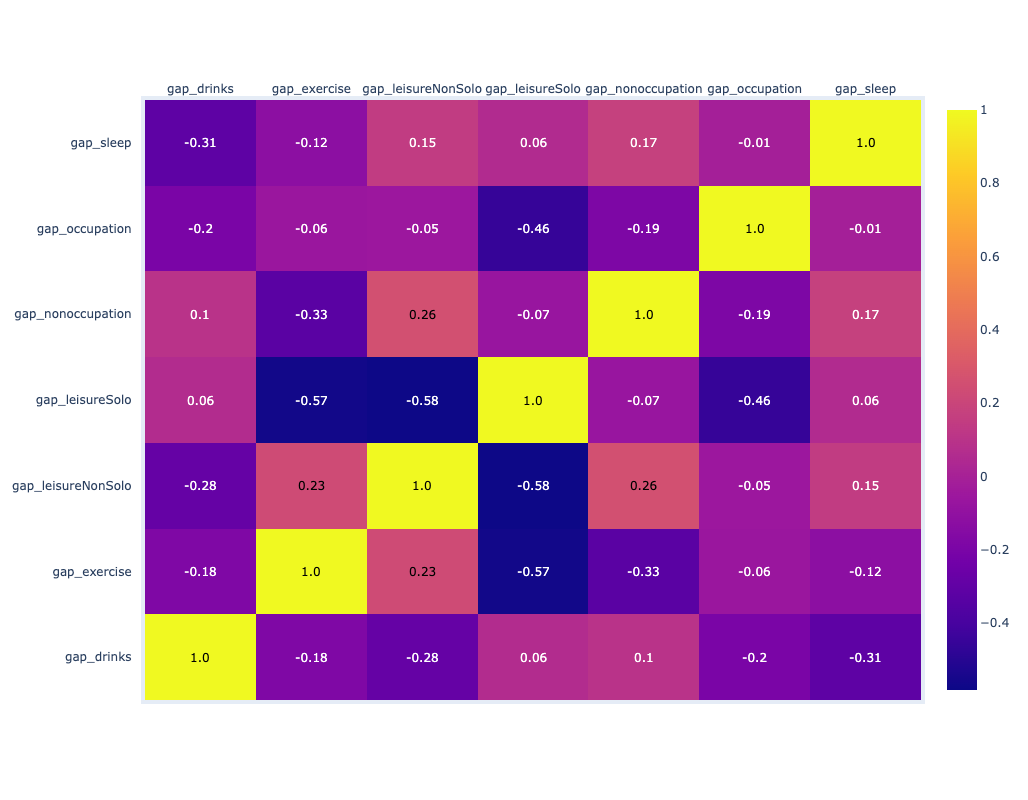

In [283]:
# clean up column names
df_plot = df_sr[gap_cols].copy()
df_plot.columns = df_plot.columns.str.replace(r'^SR_', '')

# Compute the correlation matrix
corrs = df_plot.corr()

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

fig.update_layout(
    autosize=False,
    width=850,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)


fig.show()

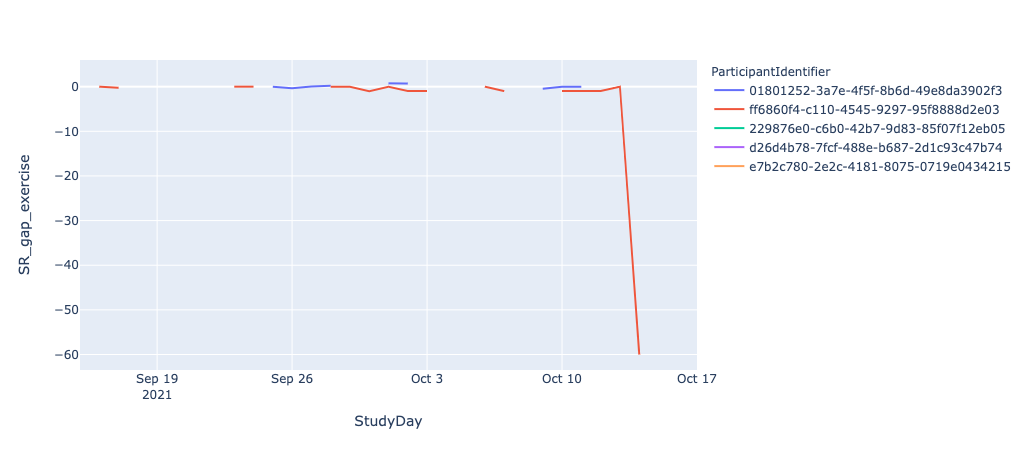

In [286]:
fig = px.line(df_sr, x="StudyDay", y="SR_gap_exercise", color='ParticipantIdentifier')
fig.show()

## Daily Goals

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p>Allows for the calculation of a daily intention-behavior gap based on 2 specific goals.</p>
    
<p class="last">Note that if someone does not respond the next day we can no longer evaluate their goal (i.e. no gap is calculated).</p>
</div>

How many study days, out of curiousity? 

In [12]:
# note that this is inclusive of both the start and end
study_days = pd.date_range(start=df_sr.StudyDay.min(),end=df_sr.StudyDay.max())

print(f'There are a total of {len(study_days)} study days.')

NameError: name 'df_sr' is not defined

Select only the data about the daily goals

In [298]:
df = app_data['SurveyQuestionResults'].loc[app_data['SurveyQuestionResults'].ResultIdentifier.str.contains('DAILY_goal'), :]
df = df[['ParticipantIdentifier', 'ResultIdentifier', 'Answers', 'StudyDay']]
df.head(3)

,ParticipantIdentifier,ResultIdentifier,Answers,StudyDay
31,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_goal_report1,100,2021-10-16
32,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_goal_report2,100,2021-10-16
33,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_goal_set1,paper improvement *3-5,2021-10-16


Don't need `...goal_set` as we don't care about the specific goal and it is non-numeric

In [299]:
# note we are also getting rid of columns from old version of the measure
to_drop = ['DAILY_goal_set1', 'DAILY_goal_set2', 'DAILY_goal_set_1', 'DAILY_goal_set_2','DAILY_goal_report_1', 'DAILY_goal_report_2']

df = df[~df.ResultIdentifier.isin(to_drop)]

In [300]:
# cast Value to numeric
df.Answers = pd.to_numeric(df.Answers)

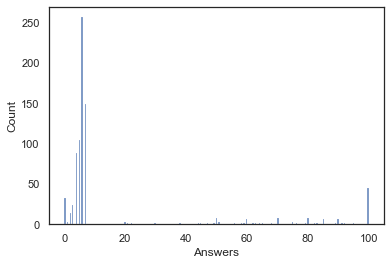

In [301]:
# take a look at the dist...(not very informative due to different scales)
sns.histplot(df.Answers);

In [302]:
# convert from long to wide
df = df.pivot_table(index=['StudyDay', 'ParticipantIdentifier'],
                    columns='ResultIdentifier', 
                    values='Answers').reset_index()

# Get rid of index name
df.columns.name = None

Clean up and standardize column names

In [303]:
df.columns = df.columns.str.replace(r'^DAILY_', '')
df.columns = df.columns.str.replace(r'^goal_set', '')

In [304]:
# add 'goal' in front of columns that start with a number
keep_same = {'StudyDay', 'ParticipantIdentifier',
              'goal_report1', 'goal_report2'
             }
df.columns = ['goal' + str(col) if col not in keep_same else col for col in df.columns]

# add SR in front of columns to indicate self report
keep_same = {'StudyDay', 'ParticipantIdentifier',
             }

# Rename columns (add prefix SR for self report)
df.columns = ['SR_' + str(col) if col not in keep_same else col for col in df.columns]
df.head(3)

,StudyDay,ParticipantIdentifier,SR_goal_report1,SR_goal_report2,SR_goal1_consequences,SR_goal1_importance,SR_goal1_motivationExternal,SR_goal1_motivationInternal,SR_goal2_consequences,SR_goal2_importance,SR_goal2_motivationExternal,SR_goal2_motivationInternal
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,92.0,100.0,4.0,6.0,3.0,5.0,3.0,4.0,5.0,5.0
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,80.0,60.0,5.0,7.0,6.0,6.0,6.0,6.0,7.0,6.0
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,60.0,80.0,6.0,7.0,5.0,7.0,5.0,6.0,4.0,7.0


---
Loop through and subtract the next day's `past24` value from the current days `next24` value

FIRST: groupby subject and then move all goal evaluations down one row (or copy to next row?)

Logic check if they have a value from the previous day
- Yes?
    - Then add/overwrite! the previous day's goal evaluation
- No? 
    - Then delete

In [305]:
# make column that indicates if the subject responded the next day



# group by subject and then move all goal evaluations from the previous day to the current day with the gap measure.
# basically we are trying to associate the subjects thoughts about the goal with the gap
# worth noting that in general we are always a day behind with our gap since we are getting the "reports" of the previous day...


### Join

In [308]:
# join
df_sr = df_sr.merge(df, how='left', on=['ParticipantIdentifier', 'StudyDay'])
df_sr.head(3)

,StudyDay,ParticipantIdentifier,SR_affect_neg_angry,SR_affect_neg_ashamed,SR_affect_neg_bored,SR_affect_neg_depressed,SR_affect_neg_embarrassed,SR_affect_neg_frustrated,SR_affect_neg_guilty,SR_affect_neg_lazy,...,SR_goal1_consequences,SR_goal1_importance,SR_goal1_motivationExternal,SR_goal1_motivationInternal,SR_goal2_consequences,SR_goal2_importance,SR_goal2_motivationExternal,SR_goal2_motivationInternal,SR_goal1_gap,SR_goal2_gap
0,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,4.0,6.0,3.0,5.0,3.0,4.0,5.0,5.0,NaN,NaN
1,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,1.0,2.0,3.0,4.0,1.0,2.0,2.0,3.0,...,5.0,7.0,6.0,6.0,6.0,6.0,7.0,6.0,NaN,NaN
2,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,2.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0,...,6.0,7.0,5.0,7.0,5.0,6.0,4.0,7.0,NaN,NaN


## Weekly Goals

## Monthly Goals

# Export DF

In [309]:
df_sr.to_csv('data/features/self_report_features.csv')